# import

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.executable

'/home/lcances/.miniconda3/envs/dct/bin/python'

In [3]:
import os
os.environ["MKL_NUM_THREADS"] = "2"
os.environ["NUMEXPR_NU M_THREADS"] = "2"
os.environ["OMP_NUM_THREADS"] = "2"
import time
from types import MethodType

import numpy
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.cuda.amp import autocast

from torch.optim.lr_scheduler import LambdaLR
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader

In [4]:
from SSL.util.model_loader import load_model
from SSL.util.loaders import load_dataset, load_optimizer, load_callbacks, load_preprocesser
from SSL.util.checkpoint import CheckPoint, mSummaryWriter
from SSL.util.utils import reset_seed, get_datetime, track_maximum, DotDict

from metric_utils.metrics import CategoricalAccuracy, FScore, ContinueAverage

# Arguments

In [5]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--from_config", default="", type=str)
parser.add_argument("-d", "--dataset_root", default="../datasets", type=str)
parser.add_argument("-D", "--dataset", default="SpeechCommand", type=str, help="available [ubs8k | cifar10]")

group_t = parser.add_argument_group("Commun parameters")
group_t.add_argument("-m", "--model", default="wideresnet28_2", type=str)
group_t.add_argument("--supervised_ratio", default=0.1, type=float)
group_t.add_argument("--batch_size", default=256, type=int)
group_t.add_argument("--nb_epoch", default=100, type=int)
group_t.add_argument("--learning_rate", default=0.003, type=float)
group_t.add_argument("--resume", action="store_true", default=False)
group_t.add_argument("--preload_dataset", action="store_true", default=False)
group_t.add_argument("--seed", default=1234, type=int)

group_m = parser.add_argument_group("Model parameters")
group_m.add_argument("--num_classes", default=12, type=int)

group_u = parser.add_argument_group("Datasets parameters")
group_u.add_argument("-t", "--train_folds", nargs="+", default=[1, 2, 3, 4], type=int)
group_u.add_argument("-v", "--val_folds", nargs="+", default=[5], type=int)

group_l = parser.add_argument_group("Logs")
group_l.add_argument("--checkpoint_root", default="../model_save/", type=str)
group_l.add_argument("--tensorboard_root", default="../tensorboard/", type=str)
group_l.add_argument("--checkpoint_path", default="supervised", type=str)
group_l.add_argument("--tensorboard_path", default="supervised", type=str)
group_l.add_argument("--tensorboard_sufix", default="", type=str)

args = parser.parse_args("")

args.tensorboard_path = os.path.join(args.tensorboard_root, args.dataset, args.tensorboard_path)
args.checkpoint_path = os.path.join(args.checkpoint_root, args.dataset, args.checkpoint_path)

In [6]:
vars(args)

{'from_config': '',
 'dataset_root': '../datasets',
 'dataset': 'SpeechCommand',
 'model': 'wideresnet28_2',
 'supervised_ratio': 0.1,
 'batch_size': 256,
 'nb_epoch': 100,
 'learning_rate': 0.003,
 'resume': False,
 'preload_dataset': False,
 'seed': 1234,
 'num_classes': 12,
 'train_folds': [1, 2, 3, 4],
 'val_folds': [5],
 'checkpoint_root': '../model_save/',
 'tensorboard_root': '../tensorboard/',
 'checkpoint_path': '../model_save/SpeechCommand/supervised',
 'tensorboard_path': '../tensorboard/SpeechCommand/supervised',
 'tensorboard_sufix': ''}

# initialisation

In [7]:
reset_seed(args.seed)


trainer = SupervisedTrainer("cnn03", "esc10")
trainer.init_trainer(
    parameters=vars(args),
    seed = args.seed,
    num_workers=0,
    pin_memory=True,
    verbose = 2
)

In [8]:
# from SSL.trainers.esc import SupervisedTrainer
from SSL.trainers.trainers import Trainer

class SupervisedTrainer(Trainer):
    def __init__(self, model: str, dataset: str):
        super().__init__(model, "supervised", dataset)

trainer = SupervisedTrainer(args.model, args.dataset)

# Prepare the dataset

In [9]:
trainer.load_transforms()

Load the transformation
################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



In [10]:
from SSL.dataset_loader.speechcommand import SpeechCommand10
def _load_dataset(self, parameters: dict):
    print("Load the dataset")
    outputs = load_dataset(
        framework=self.framework,
        train_transform=self.train_transform,
        val_transform=self.val_transform,
        **parameters
    )

    self.manager, self.train_loader, self.val_loader = outputs
    self.input_shape = self._get_input_shape()

    dataset_path = parameters["dataset_root"]
    test_dataset = SpeechCommand10(root=dataset_path, subset="testing", transform=self.train_transform, download=True, percent_to_drop=0.0)
    self.test_loader = DataLoader(test_dataset, batch_size=parameters["batch_size"], shuffle=True,
    num_workers=parameters["num_workers"], pin_memory=parameters["pin_memory"])

trainer.load_dataset = MethodType(_load_dataset, trainer)

In [11]:
parameters = dict(
    dataset=args.dataset,

    dataset_root = args.dataset_root,
    supervised_ratio = args.supervised_ratio,
    batch_size = args.batch_size,
    train_folds = args.train_folds,
    val_folds = args.val_folds,
    
    num_workers=0,
    pin_memory=True,

    verbose = 2,
)

trainer.load_dataset(parameters)

Load the dataset
../datasets/SpeechCommands/speech_commands_v0.02


FileNotFoundError: [Errno 2] No such file or directory: '../datasets/speech_commands_v0.02.tar.gz'

In [198]:
len(trainer.train_loader.dataset), len(trainer.val_loader.dataset), len(trainer.test_loader.dataset)
# len(trainer.test_loader.dataset)

(60206, 9981, 11005)

# Prep model

In [199]:
trainer.create_model()


Create the model
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 32]             864
       BatchNorm2d-2           [-1, 32, 64, 32]              64
              ReLU-3           [-1, 32, 64, 32]               0
         MaxPool2d-4           [-1, 32, 32, 16]               0
            Conv2d-5           [-1, 32, 32, 16]           9,216
       BatchNorm2d-6           [-1, 32, 32, 16]              64
              ReLU-7           [-1, 32, 32, 16]               0
            Conv2d-8           [-1, 32, 32, 16]           9,216
       BatchNorm2d-9           [-1, 32, 32, 16]              64
             ReLU-10           [-1, 32, 32, 16]               0
       BasicBlock-11           [-1, 32, 32, 16]               0
           Conv2d-12           [-1, 32, 32, 16]           9,216
      BatchNorm2d-13           [-1, 32, 32, 16]              64
             ReLU-14  

# Training initialization

## Losses

In [200]:
from types import MethodType

def init_loss(self):
    self.loss_ce = nn.CrossEntropyLoss(reduction="mean")

trainer.init_loss = MethodType(init_loss, trainer)

In [201]:
trainer.init_loss()

## optimizer & callbacks

In [202]:
parameters=DotDict(
    learning_rate=args.learning_rate,
)
trainer.init_optimizer(parameters)


Initialize optimizer


In [203]:
parameters=DotDict(
    nb_epoch=args.nb_epoch,
    optimizer=trainer.optimizer,
)
trainer.init_callbacks(parameters)

Initialize callbacks


# Logs and checkpoint

In [204]:
# Logs
parameters=DotDict(
    supervised_ratio=args.supervised_ratio
)
trainer.init_logs(parameters)

# Save all the parameters
tensorboard_params = {}
for key, value in args.__dict__.items():
    tensorboard_params[key] = str(value)
trainer.tensorboard.add_hparams(tensorboard_params, {})


Prepare the log system


In [205]:
# Checkpoint
parameters=DotDict(
    supervised_ratio=args.supervised_ratio
)
trainer.init_checkpoint(parameters)

Prepare the checkpoint system


## Metrics

In [206]:
# Metrics
def init_metrics(self):
    self.metrics = DotDict(
        fscore_fn=FScore(),
        acc_fn=CategoricalAccuracy(),
        avg_fn=ContinueAverage(),
    )
    self.maximum_tracker = track_maximum()

trainer.init_metrics = MethodType(init_metrics, trainer)
trainer.init_metrics()

## training function

In [207]:
def set_printing_form(self):
    UNDERLINE_SEQ = "\033[1;4m"
    RESET_SEQ = "\033[0m"

    header_form = "{:<8.8} {:<6.6} - {:<6.6} - {:<8.8} {:<6.6} - {:<9.9} {:<12.12}| {:<9.9}- {:<6.6}"
    value_form  = "{:<8.8} {:<6} - {:<6} - {:<8.8} {:<6.4f} - {:<9.9} {:<10.4f}| {:<9.4f}- {:<6.4f}"

    self.header = header_form.format(
        ".               ", "Epoch", "%", "Losses:", "ce", "metrics: ", "acc", "F1 ","Time"
    )

    self.train_form = value_form
    self.val_form = UNDERLINE_SEQ + value_form + RESET_SEQ

In [208]:
def train_fn(self, epoch: int):
    # aliases
    M = self.metrics
    T = self.tensorboard.add_scalar
    nb_batch = len(self.train_loader)

    start_time = time.time()
    print("")

    self.reset_metrics()
    self.model.train()

    for i, (X, y) in enumerate(self.train_loader):
        X = X.cuda()
        y = y.cuda()

        logits = self.model(X)
        loss = self.loss_ce(logits, y)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        with torch.set_grad_enabled(False):
            pred = torch.softmax(logits, dim=1)
            pred_arg = torch.argmax(logits, dim=1)
            y_one_hot = F.one_hot(y, num_classes=self.num_classes)

            acc = M.acc_fn(pred_arg, y).mean
            fscore = M.fscore_fn(pred, y_one_hot).mean
            avg_ce = M.avg_fn(loss.item()).mean

            # logs
            print(self.train_form.format(
                "Training: ",
                epoch + 1,
                int(100 * (i + 1) / nb_batch),
                "", avg_ce,
                "", acc, fscore,
                time.time() - start_time
            ), end="\r")

    T("train/Lce", avg_ce, epoch)
    T("train/f1", fscore, epoch)
    T("train/acc", acc, epoch)

In [209]:
def val_fn(self, epoch: int):
    # aliases
    M = self.metrics
    T = self.tensorboard.add_scalar
    nb_batch = len(self.val_loader)

    start_time = time.time()
    print("")

    self.reset_metrics()
    self.model.eval()

    with torch.set_grad_enabled(False):
        for i, (X, y) in enumerate(self.val_loader):
            X = X.cuda()
            y = y.cuda()

            logits = self.model(X)
            loss = self.loss_ce(logits, y)

            # metrics
            pred = torch.softmax(logits, dim=1)
            pred_arg = torch.argmax(logits, dim=1)
            y_one_hot = F.one_hot(y, num_classes=self.num_classes)

            acc = M.acc_fn(pred_arg, y).mean
            fscore = M.fscore_fn(pred, y_one_hot).mean
            avg_ce = M.avg_fn(loss.item()).mean

            # logs
            print(self.val_form.format(
                "Validation: ",
                epoch + 1,
                int(100 * (i + 1) / nb_batch),
                "", avg_ce,
                "", acc, fscore,
                time.time() - start_time
            ), end="\r")

    T("val/Lce", avg_ce, epoch)
    T("val/f1", fscore, epoch)
    T("val/acc", acc, epoch)

    T("hyperparameters/learning_rate", self._get_lr(), epoch)

    T("max/acc", self.maximum_tracker("acc", acc), epoch)
    T("max/f1", self.maximum_tracker("f1", fscore), epoch)

    self.checkpoint.step(acc)
    for c in self.callbacks:
        c.step()
        pass

In [210]:
def test_fn(self):
    # aliases
    M = self.metrics
    T = self.tensorboard.add_scalar
    nb_batch = len(self.val_loader)

    # Load best epoch
    self.checkpoint.load_best()

    start_time = time.time()
    print("")

    self.reset_metrics()
    self.model.eval()

    with torch.set_grad_enabled(False):
        for i, (X, y) in enumerate(self.test_loader):
            X = X.cuda()
            y = y.cuda()

            logits = self.model(X)
            loss = self.loss_ce(logits, y)

            # metrics
            pred = torch.softmax(logits, dim=1)
            pred_arg = torch.argmax(logits, dim=1)
            y_one_hot = F.one_hot(y, num_classes=self.num_classes)

            acc = M.acc_fn(pred_arg, y).mean
            fscore = M.fscore_fn(pred, y_one_hot).mean
            avg_ce = M.avg_fn(loss.item()).mean

            # logs
            print(self.val_form.format(
                "Testing: ",
                1,
                int(100 * (i + 1) / nb_batch),
                "", avg_ce,
                "", acc, fscore,
                time.time() - start_time
            ), end="\r")

        print("final accuracy is %f" % acc)

    self.maximum_tracker("test/acc", acc)

In [211]:
trainer.set_printing_form = MethodType(set_printing_form, trainer)
trainer.train_fn = MethodType(train_fn, trainer)
trainer.val_fn = MethodType(val_fn, trainer)
trainer.test_fn = MethodType(test_fn, trainer)

# Training

In [212]:
# Fit function
trainer.set_printing_form()
print(trainer.header)

start_epoch = trainer.checkpoint.epoch_counter
end_epoch = args.nb_epoch

for e in range(start_epoch, args.nb_epoch):
    trainer.train_fn(e)
    trainer.val_fn(e)
    
    trainer.tensorboard.flush()

.        Epoch  - %      - Losses:  ce     - metrics:  acc         | F1       - Time  

Training 1      - 100    -          0.6649 -           0.7826    | 0.7641   - 84.5769
Validati 1      - 100    -          0.5149 -           0.8399    | 0.8409   - 11.9251
Training 2      - 100    -          0.2451 -           0.9199    | 0.9202   - 13.5870

Training 3      - 100    -          0.1808 -           0.9412    | 0.9422   - 13.7395

Training 4      - 100    -          0.1482 -           0.9515    | 0.9523   - 13.6642
Validati 4      - 100    -          0.1782 -           0.9430    | 0.9440   - 0.7265
Training 5      - 100    -          0.1218 -           0.9606    | 0.9613   - 13.8442
Validati 5      - 100    -          0.2162 -           0.9326    | 0.9339   - 0.7304
Training 6      - 100    -          0.1061 -           0.9657    | 0.9660   - 13.6966
Validati 6      - 100    -          0.1751 -           0.9451    | 0.9452   - 0.7295
Training 7      - 100    -          0.0940 -         

In [213]:
if args.dataset.lower() == "speechcommand":
    trainer.test_fn()

    print(trainer.maximum_tracker.max["test/acc"])


final accuracy is 0.969828
tensor(0.9698, device='cuda:0')


## display

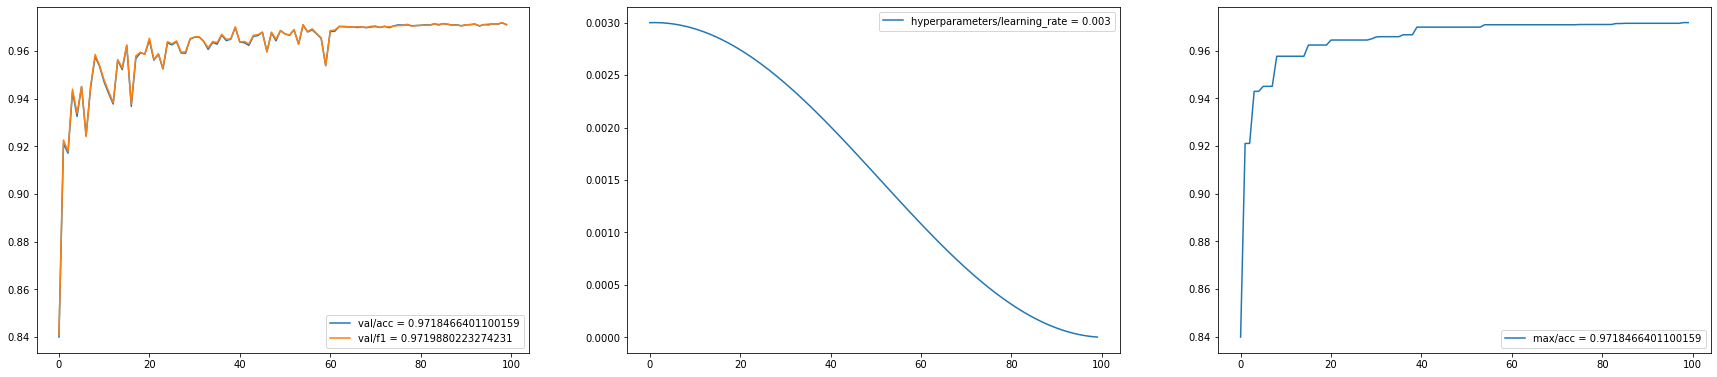

In [214]:
import matplotlib.pyplot as plt
import numpy as np

T=trainer.tensorboard.history

x = list(range(trainer.checkpoint.epoch_counter))
sm = lambda y, w: np.convolve(y, np.ones(w)/w, mode='same')
pp = lambda k: plt.plot(x, T[k], label=f"{k} = {max(T[k])}")
spp = lambda k: plt.plot(x, sm(T[k], 5), label=f"{k} = {max(T[k])}")


plt.figure(0, figsize=(30, 14))
plt.subplot(2, 3, 1)
pp("val/acc")
pp("val/f1")
plt.legend()

plt.subplot(2, 3, 2)
pp("hyperparameters/learning_rate")
plt.legend()

plt.subplot(2, 3, 3)
pp("max/acc")
plt.legend()

plt.show()

# checking some stuf

In [219]:
trainer.checkpoint.load_best()
trainer.model.eval()

nb_true_positive = torch.zeros((12,))
nb_positive = torch.zeros((12,))

with torch.set_grad_enabled(False):
    for i, (X, y) in enumerate(trainer.test_loader):
        X = X.cuda()
        y = y.cuda()

        logits = trainer.model(X)

        pred = torch.argmax(logits, dim=1)
        pred_one_hot = F.one_hot(pred, num_classes=12)
        y_one_hot = F.one_hot(y, num_classes=12)

        nb_true_positive += (pred_one_hot * y_one_hot).sum(dim=0).cpu()
        nb_positive += y_one_hot.sum(dim=0).cpu()

In [228]:
np.unique(pred.cpu())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 11])

In [220]:
class_acc = nb_true_positive / nb_positive
print(class_acc)

trainer.test_loader.dataset.target_mapper

tensor([0.9761, 0.9432, 0.9529, 0.9064, 0.9757, 0.9545, 0.9453, 0.9293, 0.9279,
        0.9830,    nan, 0.9817])


{'yes': 0,
 'no': 1,
 'up': 2,
 'down': 3,
 'left': 4,
 'right': 5,
 'off': 6,
 'on': 7,
 'go': 8,
 'stop': 9,
 'silence': 10,
 '_background_noise_': 11,
 'bed': 11,
 'bird': 11,
 'cat': 11,
 'dog': 11,
 'eight': 11,
 'five': 11,
 'follow': 11,
 'forward': 11,
 'four': 11,
 'happy': 11,
 'house': 11,
 'learn': 11,
 'marvin': 11,
 'nine': 11,
 'one': 11,
 'seven': 11,
 'sheila': 11,
 'six': 11,
 'three': 11,
 'tree': 11,
 'two': 11,
 'visual': 11,
 'wow': 11,
 'zero': 11,
 'backward': 11}

In [221]:
class_value = zip(list(trainer.test_loader.dataset.target_mapper.keys())[:12], class_acc)
for k, v in class_value:
    print("%s : %.4f;" % (k, v))

yes : 0.9761;
no : 0.9432;
up : 0.9529;
down : 0.9064;
left : 0.9757;
right : 0.9545;
off : 0.9453;
on : 0.9293;
go : 0.9279;
stop : 0.9830;
silence : nan;
_background_noise_ : 0.9817;


In [222]:
class_value = zip(list(trainer.test_loader.dataset.target_mapper.keys())[:12], class_acc)
class_acc = [c.item() for c in class_acc]

print(";".join(list(trainer.test_loader.dataset.target_mapper.keys())[:12]))
print(";".join(map(str, class_acc)))

yes;no;up;down;left;right;off;on;go;stop;silence;_background_noise_
0.9761336445808411;0.9432098865509033;0.9529411792755127;0.9064039587974548;0.9757281541824341;0.9545454382896423;0.9452736377716064;0.9292929172515869;0.927860677242279;0.9829683899879456;nan;0.9816765189170837


# ♫♪.ılılıll|̲̅̅●̲̅̅|̲̅̅=̲̅̅|̲̅̅●̲̅̅|llılılı.♫♪

# Testing `fit` function from trainer.

from SSL.trainers import SupervisedTrainer

training_params=dict(
    dataset=args.dataset,

    dataset_root = args.dataset_root,
    supervised_ratio = args.supervised_ratio,
    batch_size = args.batch_size,
    train_folds = args.train_folds,
    val_folds = args.val_folds,
    learning_rate=args.learning_rate,
    nb_epoch=args.nb_epoch,
    seed=args.seed,

)
other_params = dict(
    num_workers=0,
    pin_memory=True,
    verbose = 2,
)

trainer = SupervisedTrainer("cnn03", "esc10")
trainer.init_trainer(
    training_params,
    **other_params
    
)

trainer.fit()

# Cross validation

trainer = SupervisedTrainer("wideresnet28_2", "esc10")

train_folds = [[1, 2, 3, 4],
               [2, 3, 4, 5],
               [3, 4, 5, 1],
               [4, 5, 1, 2],
               [5, 1, 2, 3]]
val_folds = [[5], [1], [2], [3], [4]]

for tf, vf in zip(train_folds, val_folds):
    training_params["train_folds"] = tf
    training_params["val_folds"] = vf

    trainer.init_trainer(
        training_params,
        **other_params
    )

    trainer.fit()
    trainer.close()

# Grid search seed

import numpy as np
seeds = np.random.randint(10000, size=(1))
history = {}

trainer = SupervisedTrainer("wideresnet28_2", "esc10")

train_folds = [1, 2, 3, 4]
val_folds = [5]
seeds = np.random

for seed in seeds:
    training_params["train_folds"] = [1, 2, 3, 4]
    training_params["val_folds"] = [5]
    training_params["seed"] = seed

    trainer.init_trainer(
        training_params,
        **other_params
    )

    trainer.fit()

    history[seed] = trainer.maximum_tracker
    trainer.close()